<h1><center>MASKTUNE: Mitigating Spurious Correlations by forcing to explore</center></h1>

Spurious correlations are coincidental feature associations formed between a subset of the input and
target variables.
<br>The presence of spurious correlations in training data can cause over-parameterized deep neural networks to fail, often drastically, when such correlations do not hold in test data. 
<br><br>Quick example: We need to classify cows and camels inside images. With high probability in the train dataset used for this classification problem cows are in images with a green field in background and similarly form camels that have desert in background. What if in testing phase we pass to the trained model a cow in an images with desert in background? Maybe the model could classify wrong the cow object and output a wrong result! The problem is that the model has learned the correlations desert-camel and green field-cow.
<br><br>MaskTune has the goal to reduce this type of spurious correlations. How?
<br>MaskTune forces the model to explore other input variables by <b>masking</b> the ones that have already been considered discriminatory. 


 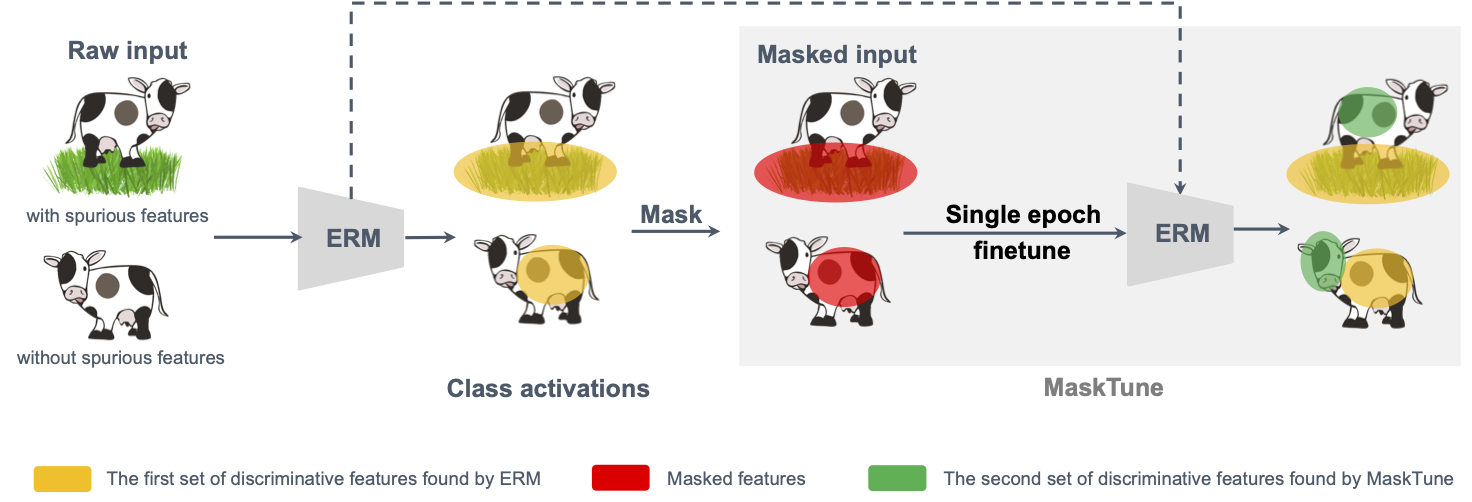

<b>MaskTune is a single-epoch finetuning technique </b> that prevents a model from learning only the “first” simplest mapping from input to the corresponding target. 
<br>After the Train phase, the model know how to extract features from inputs and then classify it. Maybe those features rely on spurious correlations and so we want to force the model to explore new input variables. In this scenario MaskTune starts to act.
<br>As first a new train dataset is created. This is formed from the one used for previous training phase but inputs are partially masked.
<br>This new dataset is used to finetune the model with a final training epoch. 
<br>As result the finetuned model is expected to be more robust to test data where the spurious correlations appear because the model is forced to explore new parts of the input images and not the previous ones learned since they are masked. 

MaskTune is applied to two main tasks: 
>a) robustness to spurious correlations;  

>b) selective classification (classification with rejection option).

We cover two different datasets under (a): MNIST with synthetic spurious
features and CelebA  
We cover two different datasets under (b): CIFAR-10 and SVHN

<hr>

In [2]:
#only in google colab
!git clone https://github.com/Giordano-Cicchetti/MaskTune_NN/
!cp MaskTune_NN/MNIST/* /content -r
!rm MaskTune_NN/ -r

Cloning into 'MaskTune_NN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 111 (delta 47), reused 66 (delta 28), pack-reused 0
Receiving objects: 100% (111/111), 4.38 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
!pip install grad-cam

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from TrainMNIST import *


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

This notebook is focused on MNIST dataset. It contains images of handwrite digits from 1 to 9 and corrispondent labels.
MNIST is formed of black and white images that can be represented as tensors of shape (1,28,28).
Over this dataset we want to perform a classification task: distinguish between two digit groups (0-4 and 5-9) in the presence of spurious features.

The first thing to do is to create the dataset used for the training and testing phase.

><b>Training dataset</b>: Starting from MNIST we divide it into two groups. Class0 is formed by digits 0,1,2,3. Class1 is formed by digits 5,6,7,8,9. Then we alter the images in order to transform black and white images into RGB images. Finally we place spourious features into the images. In particular we place 99% and 1% of the new class 0 and new class 1 data on a background with a small red square on the top left corner, respectively, and keep the remaining data intact.

><b>Test datasets</b>: two test datasets. The first is the original MNIST test dataset (of course the images are transformed in RGB images). The second is a biased test set. To create the biased test set we place all of the digits from the group “5-9” on a background with a small
red square (representing spurious features) on the top left corner and keep all of the digits from the group “0-4” unchanged. NB this is the exact opposite procedure used to form the training dataset.

The creation of these datasets and corrispondent dataloaders is done in the constructor of the class TrainMNIST. The code can be explored in the files of our GitHub repository MNIST/TrainMnist.py and MNIST/biased_mnist.py 

In [5]:
Train_Mnist = TrainMNIST(device)



Start loading data of train dataset in main memory




Start loading data of test dataset in main memory




Start loading data of test dataset in main memory




We can have a look to the images inside the created datasets

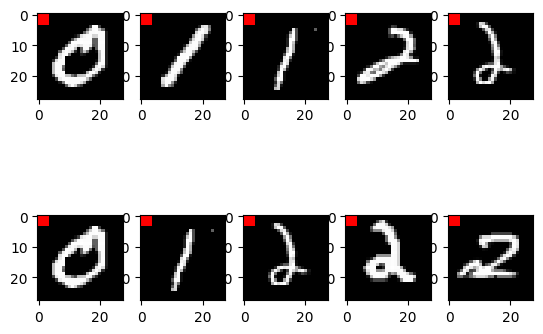

In [6]:
fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Train_Mnist.train_dataset[(i+1)*j*800][0].transpose(0,1).transpose(1,2))

We are ready to train a model that will accomplish the task of classify the digits.
>The model used is a simply CNN formed by four convolutional layer and a linear head.
We put the code of the model inside this notebook only for completeness. The same code is stored inside the file MNIST/model.py and it is referenced by the constructor of the class TrainMNIST.
<br>It is the same architecture used by the authors of the paper. Our goal is to achieve the same results using the same architecture.

>As optimizer we use SGD with a momentum of 0.9 and weight decay of 1e-4. Moreover the learning rate is 0.01 and it is decreased by a factor of 0.5 every 25 epochs.

In [ ]:
class CNN_MNIST(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        #First convolution block: Conv2d + batchNorm + Relu
        self.conv1 = nn.Sequential(
            #input: images 28x28x3 
            #output: images 26x26x16
            nn.Conv2d(3, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU()
            )
        
        #Second convolution block: Conv2d + batchNorm + Relu + MaxPool
        self.conv2 = nn.Sequential(
            #Input: images 26x26x16
            #Output: images 12x12x16
            nn.Conv2d(16, 16, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2))
            )
        #Third convolution block: Conv2d + batchNorm + Relu
        self.conv3 = nn.Sequential(
            #Input: images 12x12x16
            #Output: images 10x10x32 
            nn.Conv2d(16, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
            )
        #Fourth convolution block: Conv2d + batchNorm + Relu + MaxPool
        self.conv4 = nn.Sequential(
            #Input: images 10x10x32
            #Output: images 4x4x32
            nn.Conv2d(32, 32, (3, 3), (1, 1)),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), (2, 2)),
            )
        #Take images of shape 4x4x32 and flattened them into a tensor of 512 values
        self.flatten= nn.Flatten()

        #Sequence of two fully connected layers 
        self.linear = nn.Sequential(
            #Input: Flattened images of 512 values
            #Output: 2 logits
            nn.Linear(512, 256),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(256, self.num_classes)
        )

    def get_grad_cam_target_layer(self):
        return self.conv4[-3]

    def forward(self, x):
        #Pass inputs to the four conv layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        
        #Pass the extracted features to the fully connected classifier
        logits = self.linear(x)

        return logits

This model has been trained for 100 epoch over the biased MNIST train dataset.

The code of the training routine can be analized in the MNIST/TrainMNIST.py file.

In [23]:
Train_Mnist.train_erm(epochs=100)

validation epoch 0: 100%|██████████| 94/94 [00:05<00:00, 18.79it/s, loss=0.0176, accuracy=0.994] 


lr: 0.01


validation epoch 1: 100%|██████████| 94/94 [00:04<00:00, 20.95it/s, loss=0.00934, accuracy=0.997]


lr: 0.01


validation epoch 2: 100%|██████████| 94/94 [00:05<00:00, 17.08it/s, loss=0.0106, accuracy=0.996]


lr: 0.01


validation epoch 3: 100%|██████████| 94/94 [00:05<00:00, 18.62it/s, loss=0.00973, accuracy=0.997]


lr: 0.01


validation epoch 4: 100%|██████████| 94/94 [00:05<00:00, 17.38it/s, loss=0.00902, accuracy=0.997]


lr: 0.01


validation epoch 5: 100%|██████████| 94/94 [00:05<00:00, 17.70it/s, loss=0.00942, accuracy=0.997]


lr: 0.01


validation epoch 6: 100%|██████████| 94/94 [00:05<00:00, 18.04it/s, loss=0.00817, accuracy=0.998]


lr: 0.01


validation epoch 7: 100%|██████████| 94/94 [00:05<00:00, 17.33it/s, loss=0.0094, accuracy=0.998] 


lr: 0.01


validation epoch 8: 100%|██████████| 94/94 [00:04<00:00, 21.27it/s, loss=0.00989, accuracy=0.997]


lr: 0.01


validation epoch 9: 100%|██████████| 94/94 [00:04<00:00, 19.46it/s, loss=0.00852, accuracy=0.998]


lr: 0.01


validation epoch 10: 100%|██████████| 94/94 [00:04<00:00, 21.00it/s, loss=0.00858, accuracy=0.998]


lr: 0.01


validation epoch 11: 100%|██████████| 94/94 [00:04<00:00, 19.30it/s, loss=0.00883, accuracy=0.998]


lr: 0.01


validation epoch 12: 100%|██████████| 94/94 [00:04<00:00, 20.08it/s, loss=0.00877, accuracy=0.998]


lr: 0.01


validation epoch 13: 100%|██████████| 94/94 [00:04<00:00, 21.21it/s, loss=0.00893, accuracy=0.998]


lr: 0.01


validation epoch 14: 100%|██████████| 94/94 [00:04<00:00, 19.80it/s, loss=0.00897, accuracy=0.998]


lr: 0.01


validation epoch 15: 100%|██████████| 94/94 [00:04<00:00, 19.07it/s, loss=0.00909, accuracy=0.998]


lr: 0.01


validation epoch 16: 100%|██████████| 94/94 [00:04<00:00, 21.01it/s, loss=0.00949, accuracy=0.998]


lr: 0.01


validation epoch 17: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s, loss=0.00903, accuracy=0.998]


lr: 0.01


validation epoch 18: 100%|██████████| 94/94 [00:04<00:00, 20.22it/s, loss=0.00898, accuracy=0.998]


lr: 0.01


validation epoch 19: 100%|██████████| 94/94 [00:04<00:00, 19.14it/s, loss=0.00951, accuracy=0.998]


lr: 0.01


validation epoch 20: 100%|██████████| 94/94 [00:04<00:00, 19.20it/s, loss=0.00942, accuracy=0.998]


lr: 0.01


validation epoch 21: 100%|██████████| 94/94 [00:04<00:00, 20.94it/s, loss=0.00938, accuracy=0.998]


lr: 0.01


validation epoch 22: 100%|██████████| 94/94 [00:04<00:00, 19.04it/s, loss=0.00957, accuracy=0.998]


lr: 0.01


validation epoch 23: 100%|██████████| 94/94 [00:04<00:00, 21.05it/s, loss=0.00959, accuracy=0.998]


lr: 0.01


validation epoch 24: 100%|██████████| 94/94 [00:04<00:00, 19.26it/s, loss=0.00976, accuracy=0.998]


lr: 0.005


validation epoch 25: 100%|██████████| 94/94 [00:04<00:00, 19.64it/s, loss=0.00974, accuracy=0.998]


lr: 0.005


validation epoch 26: 100%|██████████| 94/94 [00:04<00:00, 20.52it/s, loss=0.00935, accuracy=0.998]


lr: 0.005


validation epoch 27: 100%|██████████| 94/94 [00:04<00:00, 21.32it/s, loss=0.00947, accuracy=0.998]


lr: 0.005


validation epoch 28: 100%|██████████| 94/94 [00:04<00:00, 20.98it/s, loss=0.00958, accuracy=0.998]


lr: 0.005


validation epoch 29: 100%|██████████| 94/94 [00:04<00:00, 19.38it/s, loss=0.00969, accuracy=0.998]


lr: 0.005


validation epoch 30: 100%|██████████| 94/94 [00:04<00:00, 20.38it/s, loss=0.00953, accuracy=0.998]


lr: 0.005


validation epoch 31: 100%|██████████| 94/94 [00:04<00:00, 20.45it/s, loss=0.00963, accuracy=0.998]


lr: 0.005


validation epoch 32: 100%|██████████| 94/94 [00:05<00:00, 18.50it/s, loss=0.00968, accuracy=0.998]


lr: 0.005


validation epoch 33: 100%|██████████| 94/94 [00:04<00:00, 19.12it/s, loss=0.00966, accuracy=0.998]


lr: 0.005


validation epoch 34: 100%|██████████| 94/94 [00:05<00:00, 18.69it/s, loss=0.00955, accuracy=0.998]


lr: 0.005


validation epoch 35: 100%|██████████| 94/94 [00:04<00:00, 20.83it/s, loss=0.00953, accuracy=0.998]


lr: 0.005


validation epoch 36: 100%|██████████| 94/94 [00:05<00:00, 18.56it/s, loss=0.00963, accuracy=0.998]


lr: 0.005


validation epoch 37: 100%|██████████| 94/94 [00:04<00:00, 19.17it/s, loss=0.00957, accuracy=0.998]


lr: 0.005


validation epoch 38: 100%|██████████| 94/94 [00:05<00:00, 18.23it/s, loss=0.0099, accuracy=0.998] 


lr: 0.005


validation epoch 39: 100%|██████████| 94/94 [00:05<00:00, 18.56it/s, loss=0.00961, accuracy=0.998]


lr: 0.005


validation epoch 40: 100%|██████████| 94/94 [00:04<00:00, 20.91it/s, loss=0.00996, accuracy=0.998]


lr: 0.005


validation epoch 41: 100%|██████████| 94/94 [00:04<00:00, 20.79it/s, loss=0.00992, accuracy=0.998]


lr: 0.005


validation epoch 42: 100%|██████████| 94/94 [00:04<00:00, 19.45it/s, loss=0.00987, accuracy=0.998]


lr: 0.005


validation epoch 43: 100%|██████████| 94/94 [00:04<00:00, 19.03it/s, loss=0.00992, accuracy=0.998]


lr: 0.005


validation epoch 44: 100%|██████████| 94/94 [00:04<00:00, 20.76it/s, loss=0.00986, accuracy=0.998]


lr: 0.005


validation epoch 45: 100%|██████████| 94/94 [00:04<00:00, 19.16it/s, loss=0.01, accuracy=0.998]   


lr: 0.005


validation epoch 46: 100%|██████████| 94/94 [00:04<00:00, 20.20it/s, loss=0.00982, accuracy=0.998]


lr: 0.005


validation epoch 47: 100%|██████████| 94/94 [00:04<00:00, 19.81it/s, loss=0.00985, accuracy=0.998]


lr: 0.005


validation epoch 48: 100%|██████████| 94/94 [00:04<00:00, 19.75it/s, loss=0.00989, accuracy=0.998]


lr: 0.005


validation epoch 49: 100%|██████████| 94/94 [00:04<00:00, 20.50it/s, loss=0.00993, accuracy=0.998]


lr: 0.0025


validation epoch 50: 100%|██████████| 94/94 [00:04<00:00, 19.54it/s, loss=0.0102, accuracy=0.998] 


lr: 0.0025


validation epoch 51: 100%|██████████| 94/94 [00:04<00:00, 20.21it/s, loss=0.00985, accuracy=0.998]


lr: 0.0025


validation epoch 52: 100%|██████████| 94/94 [00:04<00:00, 19.17it/s, loss=0.01, accuracy=0.998]   


lr: 0.0025


validation epoch 53: 100%|██████████| 94/94 [00:04<00:00, 19.60it/s, loss=0.0101, accuracy=0.998] 


lr: 0.0025


validation epoch 54: 100%|██████████| 94/94 [00:05<00:00, 18.75it/s, loss=0.00996, accuracy=0.998]


lr: 0.0025


validation epoch 55: 100%|██████████| 94/94 [00:05<00:00, 17.36it/s, loss=0.00992, accuracy=0.998]


lr: 0.0025


validation epoch 56: 100%|██████████| 94/94 [00:04<00:00, 19.86it/s, loss=0.01, accuracy=0.998]   


lr: 0.0025


validation epoch 57: 100%|██████████| 94/94 [00:04<00:00, 18.84it/s, loss=0.01, accuracy=0.998]   


lr: 0.0025


validation epoch 58: 100%|██████████| 94/94 [00:04<00:00, 20.38it/s, loss=0.00998, accuracy=0.998]


lr: 0.0025


validation epoch 59: 100%|██████████| 94/94 [00:04<00:00, 19.20it/s, loss=0.00993, accuracy=0.998]


lr: 0.0025


validation epoch 60: 100%|██████████| 94/94 [00:05<00:00, 17.92it/s, loss=0.00997, accuracy=0.998]


lr: 0.0025


validation epoch 61: 100%|██████████| 94/94 [00:04<00:00, 20.87it/s, loss=0.00988, accuracy=0.998]


lr: 0.0025


validation epoch 62: 100%|██████████| 94/94 [00:04<00:00, 20.05it/s, loss=0.0099, accuracy=0.998] 


lr: 0.0025


validation epoch 63: 100%|██████████| 94/94 [00:04<00:00, 19.46it/s, loss=0.00987, accuracy=0.998]


lr: 0.0025


validation epoch 64: 100%|██████████| 94/94 [00:04<00:00, 19.84it/s, loss=0.00986, accuracy=0.998]


lr: 0.0025


validation epoch 65: 100%|██████████| 94/94 [00:05<00:00, 18.31it/s, loss=0.00981, accuracy=0.998]


lr: 0.0025


validation epoch 66: 100%|██████████| 94/94 [00:04<00:00, 19.27it/s, loss=0.00997, accuracy=0.998]


lr: 0.0025


validation epoch 67: 100%|██████████| 94/94 [00:04<00:00, 20.07it/s, loss=0.00993, accuracy=0.998]


lr: 0.0025


validation epoch 68: 100%|██████████| 94/94 [00:05<00:00, 18.73it/s, loss=0.00991, accuracy=0.998]


lr: 0.0025


validation epoch 69: 100%|██████████| 94/94 [00:04<00:00, 19.47it/s, loss=0.00995, accuracy=0.998]


lr: 0.0025


validation epoch 70: 100%|██████████| 94/94 [00:04<00:00, 19.56it/s, loss=0.00986, accuracy=0.998]


lr: 0.0025


validation epoch 71: 100%|██████████| 94/94 [00:05<00:00, 17.98it/s, loss=0.00985, accuracy=0.998]


lr: 0.0025


validation epoch 72: 100%|██████████| 94/94 [00:05<00:00, 18.54it/s, loss=0.00985, accuracy=0.998]


lr: 0.0025


validation epoch 73: 100%|██████████| 94/94 [00:04<00:00, 20.96it/s, loss=0.00983, accuracy=0.998]


lr: 0.0025


validation epoch 74: 100%|██████████| 94/94 [00:05<00:00, 17.84it/s, loss=0.00983, accuracy=0.998]


lr: 0.00125


validation epoch 75: 100%|██████████| 94/94 [00:04<00:00, 18.87it/s, loss=0.01, accuracy=0.998]   


lr: 0.00125


validation epoch 76: 100%|██████████| 94/94 [00:04<00:00, 21.20it/s, loss=0.00994, accuracy=0.998]


lr: 0.00125


validation epoch 77: 100%|██████████| 94/94 [00:04<00:00, 18.96it/s, loss=0.00993, accuracy=0.998]


lr: 0.00125


validation epoch 78: 100%|██████████| 94/94 [00:04<00:00, 18.87it/s, loss=0.00985, accuracy=0.998]


lr: 0.00125


validation epoch 79: 100%|██████████| 94/94 [00:05<00:00, 17.26it/s, loss=0.00988, accuracy=0.998]


lr: 0.00125


validation epoch 80: 100%|██████████| 94/94 [00:05<00:00, 18.79it/s, loss=0.00982, accuracy=0.998]


lr: 0.00125


validation epoch 81: 100%|██████████| 94/94 [00:04<00:00, 19.61it/s, loss=0.00991, accuracy=0.998]


lr: 0.00125


validation epoch 82: 100%|██████████| 94/94 [00:05<00:00, 18.26it/s, loss=0.00977, accuracy=0.998]


lr: 0.00125


validation epoch 83: 100%|██████████| 94/94 [00:04<00:00, 19.57it/s, loss=0.00972, accuracy=0.998]


lr: 0.00125


validation epoch 84: 100%|██████████| 94/94 [00:05<00:00, 18.49it/s, loss=0.00974, accuracy=0.998]


lr: 0.00125


validation epoch 85: 100%|██████████| 94/94 [00:05<00:00, 18.74it/s, loss=0.0098, accuracy=0.998] 


lr: 0.00125


validation epoch 86: 100%|██████████| 94/94 [00:04<00:00, 19.27it/s, loss=0.00976, accuracy=0.998]


lr: 0.00125


validation epoch 87: 100%|██████████| 94/94 [00:04<00:00, 19.38it/s, loss=0.00981, accuracy=0.998]


lr: 0.00125


validation epoch 88: 100%|██████████| 94/94 [00:04<00:00, 19.61it/s, loss=0.00985, accuracy=0.998]


lr: 0.00125


validation epoch 89: 100%|██████████| 94/94 [00:04<00:00, 19.24it/s, loss=0.00984, accuracy=0.998]


lr: 0.00125


validation epoch 90: 100%|██████████| 94/94 [00:05<00:00, 17.89it/s, loss=0.00984, accuracy=0.998]


lr: 0.00125


validation epoch 91: 100%|██████████| 94/94 [00:04<00:00, 20.63it/s, loss=0.00991, accuracy=0.998]


lr: 0.00125


validation epoch 92: 100%|██████████| 94/94 [00:04<00:00, 20.17it/s, loss=0.00986, accuracy=0.998]


lr: 0.00125


validation epoch 93: 100%|██████████| 94/94 [00:04<00:00, 20.39it/s, loss=0.00987, accuracy=0.998]


lr: 0.00125


validation epoch 94: 100%|██████████| 94/94 [00:04<00:00, 20.41it/s, loss=0.00983, accuracy=0.998]


lr: 0.00125


validation epoch 95: 100%|██████████| 94/94 [00:05<00:00, 18.61it/s, loss=0.00975, accuracy=0.998]


lr: 0.00125


validation epoch 96: 100%|██████████| 94/94 [00:04<00:00, 19.02it/s, loss=0.00978, accuracy=0.998]


lr: 0.00125


validation epoch 97: 100%|██████████| 94/94 [00:04<00:00, 19.88it/s, loss=0.00988, accuracy=0.998]


lr: 0.00125


validation epoch 98: 100%|██████████| 94/94 [00:04<00:00, 20.06it/s, loss=0.00988, accuracy=0.998]


lr: 0.00125


validation epoch 99: 100%|██████████| 94/94 [00:05<00:00, 18.61it/s, loss=0.00988, accuracy=0.998]

lr: 0.00125


At the end of the training phase we can evaluate our model over the two test dataset that we built (the original MNIST test dataset and the biased one)
The results are very interesting: The model learned the correlation between the presence of the red squared (the spurious feature) and the class with label "0".

>Original Test Dataset: Since in the original test dataset the spurious feature is not present than the model is more prone to classify each digit as digit of class "1" and so the accuracy of the model decreases. Accuracy: 64%

>Biased Test Dataset: In this case the construction of the test dataset is made with the goal of confound the model as much as possible and indeed this happens. The model classify a lot of class "0" digits as class "1" digits because the red square is not presence and on the contrary class "1" digits are classified as class "0" digits since the red square is present. Accuracy:34%

In [26]:
Train_Mnist.test(Train_Mnist.test_loader_original,"best_erm_model.pt")

----------testing the model----------


test epoch 10: 100%|██████████| 79/79 [00:04<00:00, 16.98it/s, loss=1.88, accuracy=0.642]

----------Test accuracy =0.6422072784810127----------


In [27]:
Train_Mnist.test(Train_Mnist.test_loader_biased,"best_erm_model.pt")

----------testing the model----------


test epoch 10: 100%|██████████| 79/79 [00:04<00:00, 17.75it/s, loss=3.61, accuracy=0.339]

----------Test accuracy =0.3389042721518987----------


MASK THE DATA: The goal of this function is to construct a new masked dataset by concealing the most
discriminative features in the input discovered by a model after full training.

In order to mask images we use xGradCAM. Given an input image of size H x W x C, xGradCAM outputs
a localization map A of size H x W x 1, which shows the contribution of each pixel of the input
image in predicting the most probable class.

We feed the XGradCAM class with the training images and it returns the heatmaps associated to each image.
After that we construct each mask by applying a threshold function to the corrispondent heatmap. 
The threshold $t$ is set to $\mu_i + 2*\sigma_i$ where $\mu_i$ and $\sigma_i$ represent mean and standard deviation over the heatmap values for training sample $x_i$. 

The final phase is to apply the masks to the images and this has been done by just multiply images tensors element-wise with the mask tensor.  

In [ ]:
def mask_data(self, train_loader,erm_checkpoint_path: str=None):
    
    heat_map_generator = XGradCAM(
        model=self.model,
        target_layers=[self.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
    #.
    #.
    #.
    for data in tqdm(train_loader):
        # Creazione Heat-Map per batch
        images,data_paths,targets = data[0],data[1],data[2]
        hm = heat_map_generator(images)
    
        # Creazione Maschera
        mask_mean_value = np.nanmean(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
        mask_std_value = np.nanstd(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
        mask_threshold_value = mask_mean_value + 2 * mask_std_value
        masks = np.where(hm > mask_threshold_value, 0, 1)
        
        # Applicazione Maschera su immagini del batch    
        for image,mask,target in zip(images,masks,targets):
            masked_images = image*mask
            masked_images.numpy()
            target=int(target)
            save_image(masked_images, os.path.join(masked_data_dir, f"{counter_imgs}{target}.png"))
            counter_imgs += 1
    #.
    #.
    #.  
    

In [ ]:
heat_map_generator = XGradCAM(
        model=Train_Mnist.model,
        target_layers=[Train_Mnist.model.get_grad_cam_target_layer()],
        use_cuda=True,
    )
fig, axs = plt.subplots(1, 4)
image=Train_Mnist.train_dataset[0][0]
axs[0, 0].plot(image)
image= torch.unsqueeze(image,0)
image= image.to(TrainMNIST.device)
image = image.transpose(1,2).transpose(2,3)
hm = heat_map_generator(image)
axs[0, 1].plot(hm[0])
# Creazione Maschera
mask_mean_value = np.nanmean(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_std_value = np.nanstd(np.where(hm > 0, hm, np.nan), axis=(1, 2))[:, None, None]
mask_threshold_value = mask_mean_value + 2 * mask_std_value
mask = np.where(hm > mask_threshold_value, 0, 1)
axs[0, 2].plot(mask)
axs[0, 3].plot(TrainMNIST.masked_dataset[0][0])

Now the core of the Paper: The finetune function.
In this function we use the mask_data function to mask the input training data and so create a new set. Then finetune (for only one epoch) the fully trained ERM model with the new masked data to reduce over-reliance on spurious or a limited number of features.

In [28]:
def finetune(best_resume_checkpoint_path: str=None, last_resume_checkpoint_path: str=None) -> None:
  checkpoint = torch.load("last_erm_model.pt")

  if(best_resume_checkpoint_path!=None and last_resume_checkpoint_path!=None):
    #Mask the data
    Train_Mnist.mask_data(Train_Mnist.train_loader,best_resume_checkpoint_path)
    #Load the model 
    Train_Mnist.model.load_state_dict(checkpoint['model_state_dict'])
    Train_Mnist.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    Train_Mnist.lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    resume_epoch = checkpoint['epoch'] + 1

    #Run a training epoch using the masked dataset
    Train_Mnist.run_an_epoch(data_loader=Train_Mnist.masked_loader,epoch=resume_epoch,mode="train",device=Train_Mnist.device)
    val_accuracy = Train_Mnist.run_an_epoch(
        data_loader=Train_Mnist.val_loader, epoch=resume_epoch, mode="validation",device=Train_Mnist.device
    )
    #Save the finetuned model
    torch.save({
                'epoch': resume_epoch,
                'model_state_dict': Train_Mnist.model.state_dict(),
                'optimizer_state_dict': Train_Mnist.optimizer.state_dict(),
                'scheduler_state_dict': Train_Mnist.lr_scheduler.state_dict(),
                'accuracy' : val_accuracy,
                }, "masked_erm_model.pt")
    

finetune(best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")


validation epoch 100: 100%|██████████| 94/94 [00:04<00:00, 20.85it/s, loss=0.0245, accuracy=0.992]


Final tests show how powerfull can be this methodology in the presence of predominants spurious features. 

>Original Test Dataset:  Accuracy goes from 64% to 98.9% 

>Biased Test Dataset:  Accuracy goes from 34% to 98.3%

The results match perfectly the ones achieved by the original paper.


In [29]:
Train_Mnist.test(Train_Mnist.test_loader_original,"masked_erm_model.pt")

----------testing the model----------


test epoch 100: 100%|██████████| 79/79 [00:04<00:00, 17.28it/s, loss=0.0328, accuracy=0.989]

----------Test accuracy =0.9889240506329114----------


In [30]:
Train_Mnist.test(Train_Mnist.test_loader_biased,"masked_erm_model.pt")

----------testing the model----------


test epoch 100: 100%|██████████| 79/79 [00:04<00:00, 16.86it/s, loss=0.0518, accuracy=0.983]

----------Test accuracy =0.9827927215189873----------
